# News and Gun Violence:  Bias in the Writing?

### Executive Summary

The problem statement I entered this project looking for an answer to was, is there racial bias in the words used by newspapers, in this case, the New York Times, when covering mass shootings in relation to the ethnicity of the shooter. If so, does the content predict racial bias.

#### The Data
The data was initially gathered from two main sources the Stanford University Mass Shooting Database and the New York Times. I chose the Stanford database because they are among the leading data collectors when it comes to mass shootings in the US. In fact, they are the ones who created the current definition of what constitutes a mass shooting. That is if four or more people are wounded or killed. Their database consists of every incident between 1966 and March 2016. However, due to the format of the New York Times files, I was unable to get articles from the 1960s and thus only used articles from 1970 to March 2016. The New York Times was selected because it is one of a few papers who cover national news that has readily available archived articles. The data chosen from the New York Times was every article and article title related to each incident from the day of the incident and the six days following. This period was selected because it is the typical length of one news cycle.

The final data features that would be used for the model would be the Incident Name and Shooter Race features from the Stanford Database and each articles content and its title. After reviewing the ethnicities in the database, I discovered that Latin Americans were largely classified as "other" and as such I researched each individual to confirm their ethnicity and changed it in the data frame. The races included were (in order of Number of Shooters) White, Asian, African American, Latin American, and Native American or Alaska Native.


#### Preparing the Data
To prepare the data for Natural Language processing, certain steps had to occur to assure smooth processing and least amount of unnecessary words. This was done by using a function that removed non-letters, made every letter lower case, and removed the standard English dictionary words as well as my custom list of stopwords which included the location of the shooting, the shooters name, month, and the name of the incident. In addition, in using, Tokenizer, Lemmatizer, and Stemming I was able to cut down on the repeating of words that are basically the same as run, runs, running, and ran.

The other major challenge here with the data was to manage the unbalanced classes before doing a train-test split or countvectorizing. The numbers of occurrences were massively imbalanced because as expected their ethnicities were not evenly spread. The spread, in percent, is as follows:
    
    White = 70.33%
    Asian = 14.79%
    African American = 11.38%
    Latin American = 2.14%
    Native American or Alaska Native = 1.36%

These numbers are actually quite interesting when you compare them to the demographic make up of the entire US populationm, which is as follows:
    
    White = 72.4%
    Asian = 4.8%
    African American = 12.6%
    Latin American = 16.3%
    Naive American or Alaska Native = 0.9%

In addition, using the SKLearn Logistic Regression model I found that a large portion of words had no impact(positive or negative) on my variables and as such decided to remove them from my model and expediting the processing of the rest of my data.

### Model Selection
To adjust for the unbalanced classes I chose to use Random Forest Classifier as it creates multiple decision trees with Bootstrapped Aggregation to better handle the unbalanced nature of the information. In the future I hope to gather more information from more news sources to help balance the data, but as this data is sadly dependent on more mass shootings happening I do hope that the only data I can get more of is articles of past events and not of those that hopefully will be as sparse as possible in the future..

Multiple RandomForest Models were created. The first is to see what the most important features are in relation to the Shooter Race Column in general. Then the following models were generated comparing the same words from the first model to see how they interacted with each race and see if there was a clear indication of different words being used and if they are particularly geared towards a specific race.

### Statistical Analysis, Recommendations, and Next Steps
The General Random Forest generated a cross-validation score of .71. The modelling was much more precise with Latin Americans(98.1%), Native American or Alaska Native(98.8%), and Asian(98.8%).As well as 89.1% for African Americans and a surprisingly low number of 72.6% for White.

While the model appears to be precise in predicting certain races it is lacking in other areas and needs to be adjusted to counteract oversampling. Once the feature importance’s are printed out it is clear that there are no certain words that appear in an article by the New York Times that would specifically indicate the individual race of the shooter despite some that are quite compelling. While this does allow me to reject my hypothesis (good news for the New York Times) moving forward I would like to look at more national newspapers and see how they differ by location, region, political leaning. I would also like to see how the local papers covered events to see if their focuses are primarily on the crime, the shooter, and event that occurred or upon helping the families affected by the horrible events.

##### Loading Packages

In [7]:
#Importing Neccesary Packages
import pandas as pd
import matplotlib as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import random
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import itertools
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import newspaper
from newspaper import Article
from sklearn.cross_validation import cross_val_score, StratifiedKFold
%matplotlib inline

### Investigating Stanford Mass Shooting Database

In [9]:
#Importing Stanford Shooting Database
data= pd.read_excel('../Assets/MSA/Stanford_MSA_Database_for_release_06142016.xlsx')
data.head()

,CaseID,Title,Location,City,State,Latitude,Longitude,Number of Victim Fatalities,Total Number of Fatalities,Number of Victims Injured,...,History of Mental Illness - General,Data Source 1,Data Source 2,Data Source 3,Data Source 4,Data Source 5,Data Source 6,Data Source 7,Military Experience,Class
0,1,University of Texas at Austin,"Austin, Texas",Austin,Texas,30.198887,-97.844159,16,17,32,...,Yes,http://en.wikipedia.org/wiki/Charles_Whitman,"Lexington Examiner (KY) - September 23, 2012",http://news.google.com/newspapers?id=lkk0AAAAI...,http://news.google.com/newspapers?id=PPUjAAAAI...,http://books.google.com/books?id=ClYEAAAAMBAJ&...,NaN,NaN,Yes,SPK
1,2,Rose-Mar College of Beauty,"Mesa, Arizona",Mesa,Arizona,33.422687,-111.816320,5,5,1,...,Yes,"""Slaughter In The College Of Beauty."" Time 88....",Section: Lexington True Crime Examiner,http://www.nydailynews.com/news/crime/beauty-s...,http://books.google.com/books?id=Cre7qsswRiwC&...,NaN,NaN,NaN,Unknown,MS
2,3,New Orleans Police Shootings,"New Orleans, Louisiana",New Orleans,Louisiana,30.068724,-89.931474,9,10,13,...,Yes,http://news.google.com/newspapers?nid=1144&dat...,http://theadvocate.com/home/4828836-125/rampag...,http://www.trutv.com/library/crime/notorious_m...,http://books.google.com/books?id=TfEDmROcZwEC&...,NaN,NaN,NaN,Unknown,SPK
3,4,Clara Barton Elementary School,"Chicago, Illinois",Chicago,Illinois,41.839280,-87.688181,1,1,3,...,Yes,http://news.google.com/newspapers?nid=1338&dat...,http://news.google.com/newspapers?nid=1144&dat...,http://www.leagle.com/xmlResult.aspx?page=1&xm...,NaN,NaN,NaN,NaN,Unknown,MS
4,5,Olean High School,"Olean, New York",Olean,New York,42.081854,-78.432139,3,3,7,...,No,http://buffalo.ynn.com/content/top_stories/622...,School Shootings: a History Part One of a seri...,http://www.newswithviews.com/Erica/Carle10.htm,http://books.google.com/books?id=ZuKoSskEWyIC&...,"""Olean High School Shooting"". Larrie Benton Za...",NaN,NaN,Unknown,MS


In [10]:
#Dropping Columns I believed were uneccesary for this analysis though for other anaylsis I may return to it
data.drop(data.loc[:, 'Data Source 1':'Data Source 7'],axis=1, inplace=True)
data.drop(['CaseID','Number of Victim Fatalities','Shooter Age(s)','Number of Automatic Guns'
          ,'Number of Semi-Automatic Guns',"Shooter's Cause of Death",
           'Relationship to Incident Location'],axis=1,inplace=True)
data.drop(['City','State','Description','Class','History of Mental Illness - Detailed','Targeted Victim/s - Detailed'],axis=1, inplace=True)
data.drop(['Possible Motive - Detailed','Type of Gun - Detailed','Date - Detailed',
          'Number of Shotguns','Number of Rifles','Number of Handguns',
           'Total Number of Guns'],axis=1,inplace=True)


In [11]:
#Replacing Shooter Race Name with More Clear distinctions
data['Shooter Race'].replace('White American or European American','White', inplace=True)
data['Shooter Race'].replace('Black American or African American','African American', inplace=True)
data['Shooter Race'].replace('Some other race','Other', inplace=True)
data['Shooter Race'].replace('Asian American','Asian', inplace=True)
data['Shooter Race'].replace('White American or European American/Some other Race','White', inplace=True)
data['Shooter Race'].replace('Black American or African American/Unknown','African American', inplace=True)
data['Shooter Race'].replace('Asian American/Some other race','Asian', inplace=True)

### Webscraping of New York Times
This is only a sample of the scrapper to scrape articles from the 1970s. This is simply the process for one incident that was repeated for each inciden there was an article. In each decades scrapper the incidents were concatenated into one dataframe at the end.Five copies of this scraper ran for each decade collecting a total of 1,053 Articles from just over 400 incidents

In [ ]:
#Selecting Article URL
url1='http://www.nytimes.com/1975/01/01/archives/snipers-classmate-says-guns-were-whole-life-a-classmate-of-upstate.html'
url2='http://www.nytimes.com/1974/12/31/archives/3-killed-and-9-wounded-by-an-upstate-sniper-18-3-killed-and-9.html'
#Initialize List of URLS
urls=[url1,url2]
#Set up DataFrame of 
Nyt_Olean =pd.DataFrame()
#Iterate Through url list
for i in urls: 
    #select article function to iterate through articles and tell the Article package it is in English
    a=Article(i, language='en')
    #Download entire URL information
    a.download()
    #Parse and clean URL
    a.parse()
    #Selecting Article Title and Article Text and appending to dataframe
    Nyt_Olean= Nyt_Olean.append([[a.title, a.text]], ignore_index=True)
#Naming columns
Nyt_Olean.columns=['Title','Article']
#Generating Column With Incident Name
Nyt_Olean['Incident Name'] = 'Olean High School'
#Recording Race of Shooter in Column
Nyt_Olean['Shooter Race']='White'
Nyt_Olean

In [ ]:
#Concatenating all 1970s Articles
NYT_1970s=pd.concat([Nyt_NolaPD, Nyt_ClaraBarton, Nyt_Olean, Nyt_LACLC, Nyt_CSF, Nyt_GCE, Nyt_UofSC, Nyt_StAs]).reset_index()
NYT_1970s.drop(['index'],axis=1, inplace=True)
NYT_1970s

In [ ]:
#Saving to CSV
NYT_1970s.to_csv('NYT 1970s Shootings-2.csv',index=False, encoding='utf-8')

## Exploratory Data Analysis and Database Cleaning

In [12]:
#Import data
NYT1970s=pd.read_csv('../Assets/NYT 1970s Shootings-2.csv')
NYT1980s=pd.read_csv('../Assets/NYT 1980s Shootings-3.csv')
NYT1990s=pd.read_csv('../Assets/NYT 1990s Shootings-3.csv')
NYT2000s=pd.read_csv('../Assets/NYT 2000s Shootings-2.csv')
NYT2010s=pd.read_csv('../Assets/NYT 2010s-4 Shootings.csv')
shootingdb= pd.read_excel('../Assets/MSA/Stanford_MSA_Database_for_release_06142016.xlsx')

In [13]:
#Reorganize imported data as it may have been jumbled in the upload process
NYT1970s=NYT1970s[['Incident Name','Title','Article','Shooter Race']]
NYT1980s=NYT1980s[['Incident Name','Title','Article','Shooter Race']]
NYT1990s=NYT1990s[['Incident Name','Title','Article','Shooter Race']]
NYT2000s=NYT2000s[['Incident Name','Title','Article','Shooter Race']]
NYT2010s=NYT2010s[['Incident Name','Title','Article','Shooter Race']]

In [14]:
#Join all DataFrames together
NYT = pd.concat([NYT1970s,NYT1980s, NYT1990s, NYT2000s,NYT2010s])
NYT.reset_index(drop=True)

,Incident Name,Title,Article,Shooter Race
0,NOLA PD,NaN,NaN,NaN
1,Clara Barton Elementary,NaN,NaN,NaN
2,Olean High School,Sniper's Classmate Says Guns Were ‘Whole Life’,The attack at the school has stunned this comm...,White
3,Olean High School,"3 Killed and 9 Wounded By an Upstate Sniper, 18",The youth was charged with three counts of mur...,White
4,LA Computer Learning Center,NaN,NaN,NaN
5,Cal State Fullerton,NaN,NaN,NaN
6,Grover Cleveland Elementary School,San Diego Girl Slays 2 With Rifle And Wounds 9...,Special weapons and tactics officers from the ...,White
7,Grover Cleveland Elementary School,Tomboy and Gun Enthusiast,"SAN DIEGO, Jan. 29 (AP) — Brenda Spencer's cla...",White
8,Grover Cleveland Elementary School,Coast Sniper Vowed She Would ‘Do Something Big’,"SAN DIEGO, Jan. 30 — Wally Spencer's eyes were...",White
9,Univeristy of South Carolina,The New York Times,Radioactive Tritium Seizure Brings Bankruptcy ...,African American


In [15]:
#Exploratory Data Analysis Function Generated by Ritika Bhasker.
def eda(dataframe):
    print "Missing Values \n \n", dataframe.isnull().sum(),"\n" #find missing values
    print "Duplicate Rows \n", dataframe.duplicated().sum(),"\n" #find duplicated values
    print "Dataframe Types \n \n", dataframe.dtypes,"\n" #datatypes of each column
    print "Dataframe Shape \n", dataframe.shape,"\n" #number of rows and columns
    print "Dataframe Describe \n \n", dataframe.describe(include='all'),"\n" #Describe all columns
    for feature in dataframe: # Prints unique values for each column 
        print feature
        print dataframe[feature].nunique()

In [16]:
eda(NYT)

Missing Values 
 
Incident Name      0
Title            133
Article          133
Shooter Race     133
dtype: int64 

Duplicate Rows 
11 

Dataframe Types 
 
Incident Name    object
Title            object
Article          object
Shooter Race     object
dtype: object 

Dataframe Shape 
(1194, 4) 

Dataframe Describe 
 
                            Incident Name               Title  \
count                                1194                1061   
unique                                291                1021   
top     Tucscon, Arizona - Gabby Giffords  The New York Times   
freq                                   83                   7   

                                                  Article Shooter Race  
count                                                1061         1061  
unique                                               1032            8  
top     The Lede is a blog that remixes national and i...        White  
freq                                                    9     

In [17]:
#Dropping duplicates and null values
NYT.dropna(inplace=True)
NYT.drop_duplicates(inplace=True)

In [18]:
#confirming that process by rerunnin eda function
eda(NYT)

Missing Values 
 
Incident Name    0
Title            0
Article          0
Shooter Race     0
dtype: int64 

Duplicate Rows 
0 

Dataframe Types 
 
Incident Name    object
Title            object
Article          object
Shooter Race     object
dtype: object 

Dataframe Shape 
(1053, 4) 

Dataframe Describe 
 
                            Incident Name               Title  \
count                                1053                1053   
unique                                161                1021   
top     Tucscon, Arizona - Gabby Giffords  The New York Times   
freq                                   83                   7   

                                                  Article Shooter Race  
count                                                1053         1053  
unique                                               1032            8  
top     The Lede is a blog that remixes national and i...        White  
freq                                                    9          723 

In [19]:
#dropping rows containing Races classified as Two or more races, Other, and Unknown as
#they do provide us with any information towards our end goal of word orientation towards a specific
#ethnicity
NYT=NYT[~NYT['Shooter Race'].str.contains('Two or more races|Other|Unknown')]

In [20]:
#Replace N.R.A. with NRA in data frame to avoid it being split up when CountVectorizing
NYT.replace("N.R.A","NRA",inplace=True)

### Generating Stop Words

In [21]:
names=shootingdb['Shooter Name'].tolist()
incidents=NYT['Incident Name'].tolist()
location=shootingdb['Location'].tolist()
city=shootingdb['City'].tolist()
state=shootingdb['State'].tolist()
title=shootingdb['Title'].tolist()
month =['jan','feb', 'mar', 'apr','june','july','aug', 'sep','oct','nov','dec',
       'january','february','march','april','august','september','october','november','december']
day=['monday','tuesday','wednesday','thurdsday','friday','saturday','sunday']
words =['said', 'door', 'korean','english','chinese','door','whether','farook','seung','norris','hui','got'
       ,'asian','whose','without','get']
dbstops= [names + incidents + location + city + state + title + month + words +day]

In [22]:
#make list all one list
dbstop=list(itertools.chain(*dbstops))
#split on blank space
dbstop = [i.split(" ") for i in dbstop]
#Flatten List
dbstop = [item for sublist in dbstop for item in sublist]
#Make all letters Lowercase
dbstop = [i.lower() for i in dbstop]
#combine English dictionary stopwords with custom list
stop=stopwords.words('english')
stop += dbstop

### Cleaning Dataframe

In [23]:
#Function Created by General Assembly in Natural Language Processing Lab
def remove(NYT):
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", NYT) 
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                                              
    #Remove stop words
    meaningful_words = [i for i in words if not i in stop]   
    # Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [24]:
#Apply Remove Function
NYT['Title']=NYT['Title'].apply(remove)

In [25]:
NYT['Article']=NYT['Article'].apply(remove)

In [26]:
NYT.reset_index(drop=True, inplace=True)

In [27]:
#Evann G Smiths Tokenizing and Lemmatizing Function  (https://github.com/evanngsmith/GA)
lemma = WordNetLemmatizer()
re_punct = re.compile('[' + ''.join(string.punctuation) + ']')

def preprocess(text):
    try:
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if len(t) > 2]
        tokens = [lemma.lemmatize(t) for t in tokens]
        if len(tokens) == 0:
            return None
        else:
            return ' '.join(tokens)
    except:
        return None

In [28]:
#apply function to dataframe
NYT['Title']=NYT['Title'].progress_map(preprocess)

progress-bar: 100%|██████████| 1028/1028 [00:01<00:00, 877.49it/s]


In [29]:
NYT['Article']=NYT['Article'].progress_map(preprocess)

progress-bar: 100%|██████████| 1028/1028 [00:03<00:00, 279.78it/s]


In [30]:
NYT.head()

,Incident Name,Title,Article,Shooter Race
0,Olean High School,sniper classmate say gun whole,attack stunned entire year six armed robbery o...,White
1,Olean High School,killed wounded upstate sniper,charged three count last night scheduled arrai...,White
2,Grover Cleveland Elementary School,girl slays rifle wound ground,special weapon tactic officer surrounded girl ...,White
3,Grover Cleveland Elementary School,tomboy gun enthusiast,classmate described today tomboy gun enthusias...,White
4,Grover Cleveland Elementary School,coast sniper vowed would something big,wally eye morning looked driveway child arrivi...,White


##### Base Accuracy

In [32]:
#view distribution of races across dataframe
NYT['Shooter Race'].value_counts()

White                               723
Asian                               152
African American                    117
Latin American                       22
Native American or Alaska Native     14
Name: Shooter Race, dtype: int64

#### White = 68.66%
#### Asian = 14.43%
#### African American = 14.43%
#### Latin American = 2.09%
#### Native American or Alaska Native = 1.33%

### CountVectorizer

In [33]:
#Initialize vectorizer function
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None,    
                             preprocessor = None,
                             stop_words=stop,
                             max_features=1500,
                             min_df=1) 

#fit vectorization to Articles and conver to array
data_features = vectorizer.fit_transform(NYT['Article'])
data_features = data_features.toarray()
print vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=1500, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', '...e', 'without', 'get', 'monday', 'tuesday', 'wednesday', 'thurdsday', 'friday', 'saturday', 'sunday'],
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


In [34]:
#view array and its shape
print data_features.shape
print data_features

(1028, 1500)
[[0 0 1 ..., 0 4 1]
 [0 0 0 ..., 0 3 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 1 1 0]]


In [35]:
#get names of vectorized words
vocab=vectorizer.get_feature_names()
print vocab

[u'abc', u'ability', u'able', u'academic', u'access', u'according', u'account', u'accused', u'acknowledged', u'across', u'act', u'acted', u'action', u'active', u'activity', u'actually', u'added', u'adding', u'addition', u'additional', u'address', u'administration', u'administrator', u'adult', u'advertisement', u'adviser', u'advocate', u'affair', u'affect', u'afghanistan', u'african', u'aftermath', u'afternoon', u'age', u'agency', u'agent', u'ago', u'agree', u'agreed', u'ahead', u'aid', u'aide', u'alarm', u'alcohol', u'alert', u'alive', u'allow', u'allowed', u'almost', u'alone', u'along', u'already', u'also', u'although', u'always', u'ambulance', u'amendment', u'america', u'american', u'ammunition', u'among', u'anger', u'angry', u'announced', u'another', u'answer', u'anti', u'anybody', u'anyone', u'anything', u'apparent', u'apparently', u'appear', u'appearance', u'appeared', u'appears', u'approach', u'area', u'argument', u'arm', u'armed', u'around', u'arrest', u'arrested', u'arrived', u

In [36]:
#create dataframe
vocab2=pd.DataFrame(data_features, columns=vocab)
vocab2.head()

,abc,ability,able,academic,access,according,account,accused,acknowledged,across,...,written,wrong,wrote,year,yellow,yes,yesterday,yet,young,younger
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,7,0,0,1,0,4,1
1,0,0,0,1,1,2,1,0,0,0,...,0,0,0,4,0,0,0,0,3,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,2,0,0,1,0,0,0


In [37]:
#merge original dataframe with vectorized one
largedf=NYT.merge(vocab2, left_index=True  ,right_index=True, how='inner')
#renaming "fit" feature as sometimes .fit() for models and the feature are confused.
largedf = largedf.rename(columns = {'fit': 'fit_feature'})
largedf.head()

,Incident Name,Title,Article,Shooter Race,abc,ability,able,academic,access,according,...,written,wrong,wrote,year,yellow,yes,yesterday,yet,young,younger
0,Olean High School,sniper classmate say gun whole,attack stunned entire year six armed robbery o...,White,0,0,1,0,0,0,...,1,0,0,7,0,0,1,0,4,1
1,Olean High School,killed wounded upstate sniper,charged three count last night scheduled arrai...,White,0,0,0,1,1,2,...,0,0,0,4,0,0,0,0,3,0
2,Grover Cleveland Elementary School,girl slays rifle wound ground,special weapon tactic officer surrounded girl ...,White,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grover Cleveland Elementary School,tomboy gun enthusiast,classmate described today tomboy gun enthusias...,White,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Grover Cleveland Elementary School,coast sniper vowed would something big,wally eye morning looked driveway child arrivi...,White,0,0,0,0,0,0,...,0,0,0,2,0,0,1,0,0,0


In [38]:
#Genearting T/F columns according to each race
largedf['White'] = largedf['Shooter Race'] == "White"
largedf['Asian'] = largedf['Shooter Race'] == "Asian"
largedf['Latin American'] = largedf['Shooter Race'] == "Latin American"
largedf['African American'] = largedf['Shooter Race'] == "African American"
largedf['Native American or Alaska Native'] = largedf['Shooter Race'] == "Native American or Alaska Native"

In [39]:
#Convert to Integers(1 if True, 0 if False)
largedf['White'] =largedf['White'].astype(int)
largedf['African American'] =largedf['African American'].astype(int)
largedf['Asian']=largedf['Asian'].astype(int)
largedf['Latin American']=largedf['Latin American'].astype(int)
largedf['Native American or Alaska Native']=largedf['Native American or Alaska Native'].astype(int)

### Using SKlearn Logisitic Regression to Find Words with Zero Influence(Coefficents of Zero)

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [ ]:
X = largedf.loc[:,'abc':'year'] #Article Words 
y = largedf['Shooter Race'] # 
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

In [ ]:
#Running and fitting model
lm=linear_model.LogisticRegression(fit_intercept=True, penalty='l1')
lm.fit(X_train,y_train)
lm.score(X_test,y_test)
evaluate_model(lm)

In [ ]:
#zipping words from X_train to correlating coefficients
zipped1 = zip(X_train.columns, lm.coef_[0])
zipped2 = zip(X_train.columns, lm.coef_[1])
zipped3 = zip(X_train.columns, lm.coef_[2])
zipped4 = zip(X_train.columns, lm.coef_[3])
zipped5 = zip(X_train.columns, lm.coef_[4])
zipped6 = zip(X_train.columns, lm.coef_[5])

In [ ]:
#Finding out classes(i.e. races of each coef)
lm.classes_

In [ ]:
#renaming columns to know which is which
zip1=pd.DataFrame(zipped1, columns=['African American Word', 'African American Coefficient'])
zip2=pd.DataFrame(zipped2,columns=['Asian Word', 'Asian Coefficient'])
zip3=pd.DataFrame(zipped3,columns=['Latin Word', 'Latin Coefficient'])
zip4=pd.DataFrame(zipped4,columns=['Native American or Alaska Native Word', 'Native American or Alaska Native Coefficient'])
zip5=pd.DataFrame(zipped5,columns=['Two or More Word', 'Two or More Coefficient'])
zip6=pd.DataFrame(zipped6,columns=['White-Word', 'White-Coefficient'])


In [ ]:
#Merging all Dfs into one
zip12=zip1.merge(zip2, left_index=True  ,right_index=True, how='inner')
zip123=zip12.merge(zip3,left_index=True  ,right_index=True, how='inner')
zip1234=zip123.merge(zip4,left_index=True  ,right_index=True, how='inner')
zip12345=zip1234.merge(zip5,left_index=True  ,right_index=True, how='inner')
WordCoefP=zip12345.merge(zip6,left_index=True  ,right_index=True, how='inner')
WordCoefP

In [ ]:
#Zero Coefficient Columns and Renaming word for merge below
AAzeros=zip1[zip1['African American Coefficient']==0]
Lzeros=zip3[zip3['Latin Coefficient']==0]
NAANzeros=zip4[zip4['Native American or Alaska Native Coefficient']==0]
NAANzeros=NAANzeros.rename(columns={'Native American or Alaska Native Word':'Word'})
Ozero=zip5[zip5['Other Coefficient']==0]
Ozero=Ozero.rename(columns={'Other Word':'Word'})
TMzero=zip6[zip6['Two or More Coefficient']==0]
TMzero=TMzero.rename(columns={'Two or More Word':'Word'})
WZero=zip7[zip7['White-Coefficient']==0]
WZero=WZero.rename(columns={'White-Word':'Word'})

In [ ]:
#merging dataframes on Words
AAzeros=AAzeros.rename(columns={'African American Word':'Word'})
Lzeros=Lzeros.rename(columns={'Latin Word':'Word'})
AAA=AAzeros.merge(Lzeros, left_on='Word'  ,right_on='Word', how='inner')
ALN=AAA.merge(NAANzeros, left_on='Word'  ,right_on='Word', how='inner')
ALNO=ALN.merge(Ozero, left_on='Word'  ,right_on='Word', how='inner')
ALNOT=ALNO.merge(TMzero, left_on='Word'  ,right_on='Word', how='inner')
ALNOTW=ALNOT.merge(WZero, left_on='Word'  ,right_on='Word', how='inner')
ALNOTW

In [ ]:
NoImpactWords=ALNOTW['Word'].tolist()

In [ ]:
#dropping word that have a zero coefficent effect on race
largedf=largedf.drop(NoImpactWords,axis=1)

### Model - Random Forest

##### Words vs Race Column

In [42]:
#train/test split
X = largedf.loc[:,'abc':'younger'] 
y = largedf['Shooter Race']  
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(308, 1500) (308,)
(720, 1500) (720,)


In [43]:
#Evaluate Model Function from General Assembly Lab
#fits model, generates accuracy score, confusion matrix, and classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print cm
    print cr
    return a

In [44]:
#generate and fit random forest classifier model
rf = RandomForestClassifier(min_samples_split=2, n_estimators=100, criterion='gini', 
                            max_depth=10, class_weight=None,random_state=86)
evaluate_model(rf)

[[  0   0   0   0  84]
 [  0   6   0   0 100]
 [  0   0   0   0  12]
 [  0   0   0   0  10]
 [  0   0   0   0 508]]
                                  precision    recall  f1-score   support

                African American       0.00      0.00      0.00        84
                           Asian       1.00      0.06      0.11       106
                  Latin American       0.00      0.00      0.00        12
Native American or Alaska Native       0.00      0.00      0.00        10
                           White       0.71      1.00      0.83       508

                     avg / total       0.65      0.71      0.60       720



/Users/ThomasPLapinger/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.71388888888888891

In [61]:
#gridsearch Cross-Validate the parameters of the random forest model
from sklearn.grid_search import GridSearchCV

params = {'n_estimators':[1, 10, 100, 1000],
          'criterion': ['gini', 'entropy'],
          'max_depth': [1, 3, 5,7,10],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}

gsrf = GridSearchCV(rf, params, n_jobs=-1, cv=10)
gsrf.fit(X, y)
print gsrf.best_params_
print gsrf.best_score_

print gsrf.best_estimator_,
evaluate_model(gsrf.best_estimator_)

/Users/ThomasPLapinger/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ThomasPLapinger/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


KeyboardInterrupt: 

In [45]:
#Generate Dataframe of Most important features(in our case words) relating to Y column
importance = pd.DataFrame(zip(rf.feature_importances_,),
                           index=X.columns,
                           columns=['Word Importance']).sort_values('Word Importance',
                                                                   ascending=False)
importance.head(10)

,Word Importance
nbc,0.009344
sergeant,0.008198
graduate,0.008096
person,0.007768
store,0.007082
danger,0.006071
immigrant,0.005891
attack,0.005883
engineering,0.005592
another,0.005324


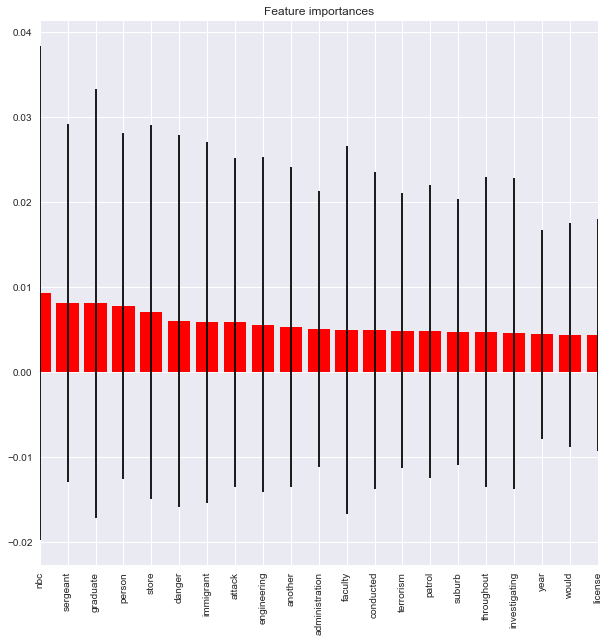

In [46]:
#Generate Feature Importances Graph(Graph Function created by General Assembly)
import matplotlib.pyplot as plt
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim(0,20)
plt.show()

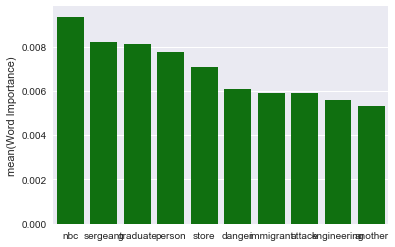

In [47]:
#Graph Top 10 Imporant Features
sns.barplot(x=importance.index[:10],y=importance['Word Importance'][:10],color='g')

In [48]:
#Generate Cross_validation score and run Stratified K fold Cross validation
cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=35)
dt = RandomForestClassifier(class_weight=None)
s = cross_val_score(dt, X, y, cv=cv, n_jobs=-1)
print "{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Tree", s.mean().round(3), s.std().round(3))

Random Forest Tree Score:	0.716 ± 0.034


The process above running the random forest classifier is repeated below, but below it is finding the words that have the highest indication of a particular race using the top 20 words from above and additional words I was interested in.

#### Words vs White

In [49]:
#White
X2 = largedf.loc[:,'abc':'younger']  #Feature 
y2 = largedf['White']  
#train/test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size = 0.3, random_state=3)
print X2_train.shape, y2_train.shape
print X2_test.shape, y2_test.shape

(308, 1500) (308,)
(720, 1500) (720,)


In [50]:
rf2 = RandomForestClassifier(min_samples_split=2, n_estimators=100, criterion='gini', 
                            max_depth=10, class_weight=None,random_state=86)
rf2.fit(X2, y2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=86,
            verbose=0, warm_start=False)

In [51]:
importance2 = pd.DataFrame(rf2.feature_importances_,
                           index=X2.columns,
                           columns=['Word Importance']).sort_values('Word Importance',
                                                                   ascending=False)
importance2.head(10)

,Word Importance
dormitory,0.020568
professor,0.011201
class,0.010708
engineering,0.007919
nbc,0.007784
injured,0.007678
student,0.007376
immigrant,0.007056
reservation,0.006832
shut,0.006620


In [52]:
cv = StratifiedKFold(y2, n_folds=10, shuffle=True, random_state=35)
s = cross_val_score(rf2, X2, y2, cv=cv, n_jobs=-1)
print "{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Tree", s.mean().round(3), s.std().round(3))

Random Forest Tree Score:	0.722 ± 0.015


#### Words vs African American

In [53]:
#African American
X3 = largedf.loc[:,'abc':'younger']  #Feature 
y3 = largedf['African American']  
#train/test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, train_size = 0.3, random_state=3)
print X3_train.shape, y3_train.shape
print X3_test.shape, y3_test.shape

(308, 1500) (308,)
(720, 1500) (720,)


In [54]:
rf3 = RandomForestClassifier(min_samples_split=2, n_estimators=100, criterion='gini', 
                            max_depth=10, class_weight=None,random_state=86)
rf3.fit(X3, y3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=86,
            verbose=0, warm_start=False)

In [55]:
importance3 = pd.DataFrame(rf3.feature_importances_,
                           index=X3.columns,
                           columns=['Word Importance']).sort_values('Word Importance',
                                                                   ascending=False)
importance3.head(10)

,Word Importance
crime,0.011957
passenger,0.011542
hearing,0.009440
avenue,0.009008
player,0.008241
minority,0.007241
officer,0.007193
waiting,0.006947
period,0.006489
financial,0.005698


In [56]:
cv = StratifiedKFold(y3, n_folds=10, shuffle=True, random_state=35)
s = cross_val_score(rf3, X3, y3, cv=cv, n_jobs=-1)
print "{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Tree", s.mean().round(3), s.std().round(3))

Random Forest Tree Score:	0.886 ± 0.004


#### Words vs Asian

In [57]:
#Asian
X4 = largedf.loc[:,'abc':'younger']  #Feature 
y4 = largedf['Asian']  
#train/test split
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, train_size = 0.3, random_state=3)
print X4_train.shape, y4_train.shape
print X4_test.shape, y4_test.shape

(308, 1500) (308,)
(720, 1500) (720,)


In [58]:
rf4 = RandomForestClassifier(min_samples_split=2, n_estimators=100, criterion='gini', 
                            max_depth=10, class_weight=None,random_state=86)
rf4.fit(X4, y4)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=86,
            verbose=0, warm_start=False)

In [59]:
importance4 = pd.DataFrame(zip(rf4.feature_importances_),
                           index=X4.columns,
                           columns=['Word Importance']).sort_values('Word Importance',
                                                                   ascending=False)
importance4.head(10)

,Word Importance
dormitory,0.021483
class,0.017056
foreign,0.015785
nbc,0.015689
fear,0.011027
islamic,0.010794
terrorist,0.010530
professor,0.009436
mass,0.009203
terrorism,0.008759


In [61]:
cv = StratifiedKFold(y4, n_folds=10, shuffle=True, random_state=35)
s = cross_val_score(rf4, X4, y4, cv=cv, n_jobs=-1)
print "{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Tree", s.mean().round(3), s.std().round(3))

Random Forest Tree Score:	0.861 ± 0.006


#### Words vs Native American or Alaska Native

In [62]:
#Native American
X5 = largedf.loc[:,'abc':'younger']  #Feature 
y5 = largedf['Native American or Alaska Native']  
#train/test split
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, train_size = 0.3, random_state=3)
print X5_train.shape, y5_train.shape
print X5_test.shape, y5_test.shape

(308, 1500) (308,)
(720, 1500) (720,)


In [63]:
rf5 = RandomForestClassifier(min_samples_split=2, n_estimators=100, criterion='gini', 
                            max_depth=10, class_weight=None,random_state=86)
rf5.fit(X5, y5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=86,
            verbose=0, warm_start=False)

In [64]:
importance5 = pd.DataFrame(zip(rf5.feature_importances_),
                           index=X5.columns,
                           columns=['Word Importance']).sort_values('Word Importance',
                                                                   ascending=False)
importance5.head(10)

,Word Importance
reservation,0.045680
indian,0.023084
fit_feature,0.016535
nazi,0.014513
teacher,0.011771
grandfather,0.010636
posted,0.009182
study,0.009173
posting,0.009043
sergeant,0.008866


In [65]:
cv = StratifiedKFold(y5, n_folds=10, shuffle=True, random_state=35)
s = cross_val_score(rf5, X5, y5, cv=cv, n_jobs=-1)
print "{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Tree", s.mean().round(3), s.std().round(3))

Random Forest Tree Score:	0.986 ± 0.005


#### Words vs Latin American

In [66]:
#Latin American
X6 = largedf.loc[:,'abc':'younger']  #Feature 
y6 = largedf['Latin American']  
#train/test split
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, train_size = 0.3, random_state=3)
print X6_train.shape, y6_train.shape
print X6_test.shape, y6_test.shape

(308, 1500) (308,)
(720, 1500) (720,)


In [67]:
rf6 = RandomForestClassifier(min_samples_split=2, n_estimators=100, criterion='gini', 
                            max_depth=10, class_weight=None,random_state=86)
rf6.fit(X6, y6)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=86,
            verbose=0, warm_start=False)

In [68]:
importance6 = pd.DataFrame(zip(rf6.feature_importances_),
                           index=X6.columns,
                           columns=['Word Importance']).sort_values('Word Importance',
                                                                   ascending=False)
importance6.head(10)

,Word Importance
specialist,0.016267
immigrant,0.010351
gathered,0.008186
agency,0.007977
request,0.007958
military,0.007694
soldier,0.007529
people,0.007330
chief,0.007230
murderer,0.007051


In [69]:
cv = StratifiedKFold(y6, n_folds=10, shuffle=True, random_state=35)
s = cross_val_score(rf6, X6, y6, cv=cv, n_jobs=-1)
print "{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Tree", s.mean().round(3), s.std().round(3))

Random Forest Tree Score:	0.981 ± 0.006
